In [ ]:
# torch with cuda
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from ultralytics import YOLO
import torch
import os

# Load a model
# model = YOLO("best.onnx")
yolo_model_s = YOLO("yolo11s.pt")
yolo_model_m = YOLO("yolo11m.pt")
# path = os.path.join(os.path.abspath("."),"License Plate Recognition.v6i.yolov11.zip")

# # Train the model
# train_results = model.train(
#     data=path,  # path to dataset YAML
#     epochs=100,  # number of training epochs
#     # workers=100,
#     # patience=100,
#     imgsz=640,  # training image size
#     device="cuda" if torch.cuda.is_available() else "cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
# )

# # Evaluate model performance on the validation set
# metrics = model.val()

# # Export the model to ONNX format
# path = model.export(format="onnx")  # return path to exported model

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from ultralytics import YOLO
from ultralytics.engine.results import Boxes, Results
from ultralytics.data.loaders import LoadStreams
import os
import cv2
from matplotlib import pyplot as plt
from safe_video import ObjectDetection, filter_results
import numpy as np
import torch
yolo_model_path = os.path.join(os.path.abspath("."), "models", "yolo11s.pt")
yolo_model = YOLO(yolo_model_path, task='detect')
plate_model_path = os.path.join(os.path.abspath("."),"models","first10ktrain","weights","best.pt")
plate_model = YOLO(plate_model_path, task='detect')
rec = ObjectDetection()


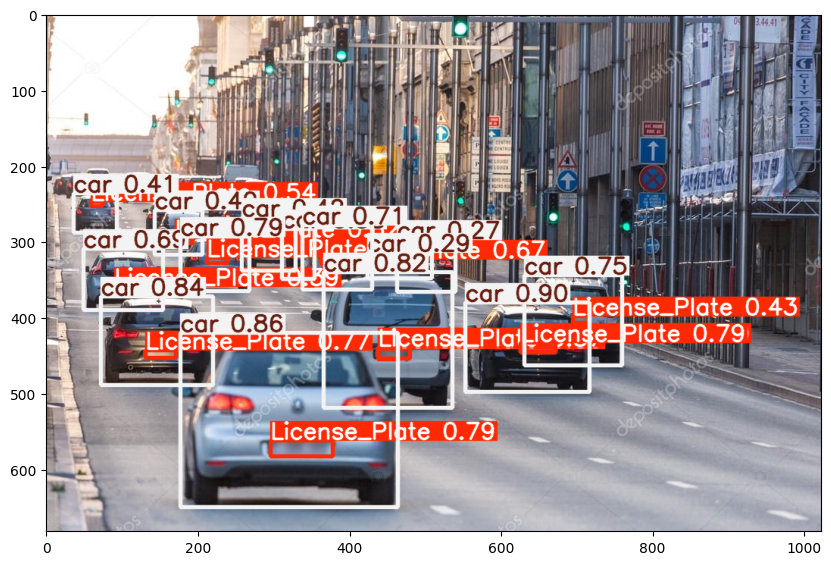

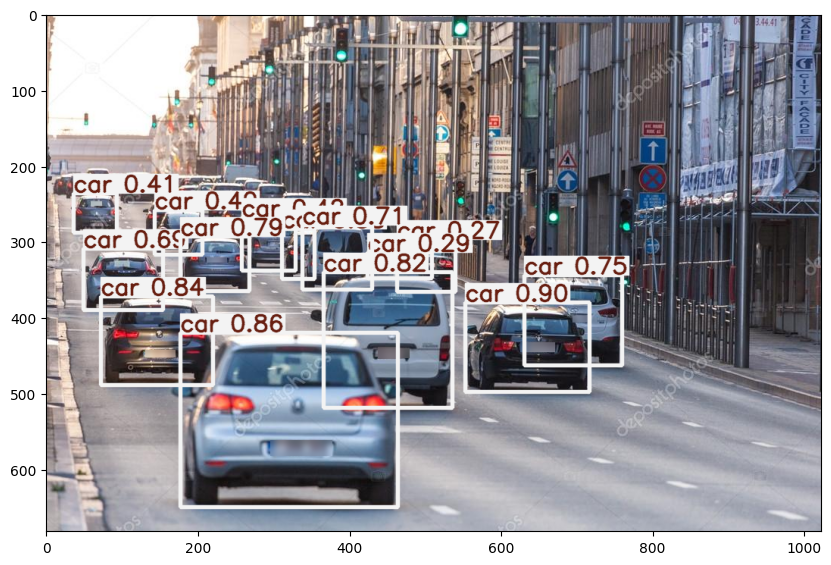

In [2]:


img_size = 10
image = cv2.imread("example.jpg")
image = image[:, :, ::-1]
rec.process_image(image, "car", "License_Plate")
# rec.analyze(image, ["traffic light", "car", "License_Plate", "barbie"])
blured = rec.apply_blur_to_image(image, rec.result, "License_Plate")
# to plot on blured image we can override the orig_img
rec.result.orig_img = blured
plt.figure(figsize=(img_size,img_size))
plt.imshow(rec.result.plot())
plt.show()


# filters only for cars, after the the analysis
rec.result = filter_results(rec.result, "car")
plt.figure(figsize=(img_size,img_size))
plt.imshow(rec.result.plot())
plt.show()

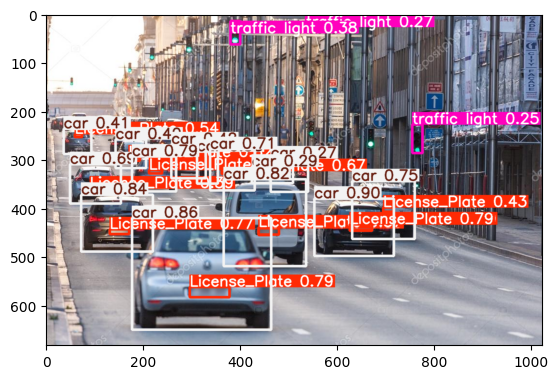

In [5]:
image = cv2.imread("example.jpg")
image = image[:, :, ::-1]

test = rec.process_image(image, ["traffic light", "car"], ["License_Plate"])
blur = rec.apply_blur_to_image(image, rec.result, "License_Plate")
# to plot on blured image we can override the orig_img
rec.result.orig_img = blur
plt.imshow(rec.result.plot())	
plt.show()


In [6]:
video = r"video1.mp4"
rec.process_video(video, primary_classes= ["car"], secondary_classes=["License_Plate"])

TypeError: ObjectDetection.process_video() got an unexpected keyword argument 'class1'